In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift

## Homework3
**Student id: U202115980 杨筠松 提高2101班**

### Task 1 同态滤波
**基本概念**：同态滤波是在频域中同时压缩动态范围并增强局部对比度，来实现图象增强的方法

**设计思想**：当用照相机采集具有很大的动态范围的景观，例如阳光灿烂时的风景照，由于底片的动态范围比较窄，照片中的对比度要降低很多。这个现象在亮区或暗区会尤其明显。图可以认为是记录了受照物体的反射光，因此可以将其分成两部分

$$f(x,y)=i(x,y)⋅r(x,y)$$

前一部分表示入射光照，r表示反射光。一般假定入射光的动态范围很大但变化缓慢，而反射光部分变化迅速，它确定了图的细部和局部的对比度。因此补救办法应该是减少$i(x,y)$并同时增加$r(x,y)$。空域中的乘积关系变到频域后不便处理，因此先将其变成相加关系然后再变到频域，经过处理后再变回来。对数运算完成这一功能

$$log f(x, y) = logi(x, y) + logr(x, y)$$

取对数后，图像灰度变化的趋势不变，即$logi(x,y)$大动态范围、缓慢变化，$logr(x,y)$变化迅速。在频域用高通滤波减少低频信号$i(x,y)$的影响，然后再反变换并取指数可以达到预期效果

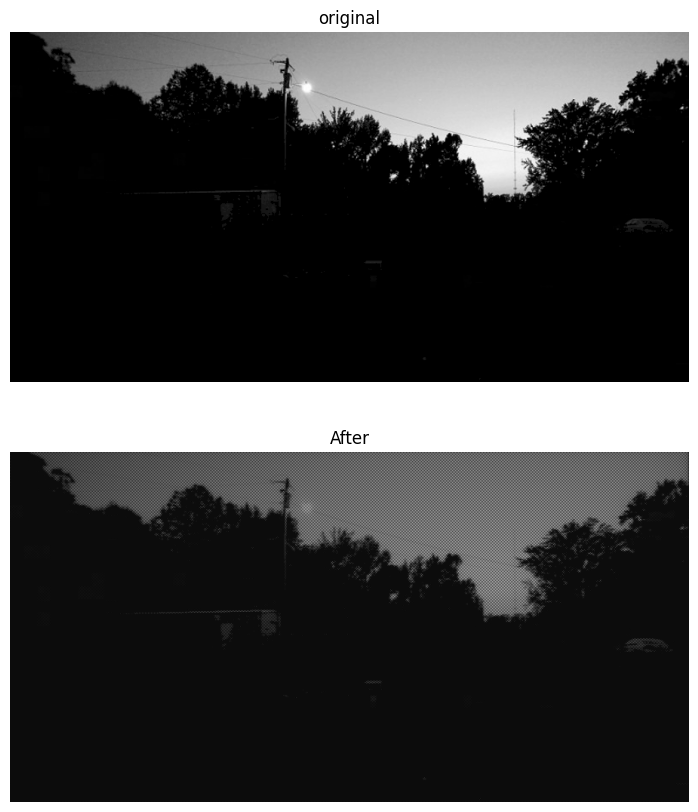

In [30]:
import numpy as np
import cv2
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

def homomorphic_filter(image_in, high, low, c, d0):
    I = image_in.astype(float)
    M, N = I.shape
    a, b = M // 2, N // 2  

    log_img = np.log1p(I)

    log_fft = fftshift(fft2(log_img))

    D = np.zeros((M, N))
    H = np.zeros((M, N))

    for i in range(M):
        for j in range(N):
            D[i, j] = np.sqrt((i - a)**2 + (j - b)**2)
            H[i, j] = (high - low) * (1 - np.exp(-c * (D[i, j]**2 / d0**2))) + low

    H = ifftshift(H)

    filtered_fft = H * log_fft

    log_ifft = ifft2(filtered_fft)
    image_out = np.real(np.expm1(log_ifft))

    return image_out

image_in = cv2.imread('data/image1.png', cv2.IMREAD_GRAYSCALE)
if image_in is None:
    print("Image not found")

image_out = homomorphic_filter(image_in, high=2.0, low=0, c=1.0, d0=max(image_in.shape))

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].imshow(image_in, cmap='gray')
axs[0].set_title('original')
axs[0].axis('off')

axs[1].imshow(image_out, cmap='gray')
axs[1].set_title('After')
axs[1].axis('off')


plt.show()


### Task2 局部增强
**基本概念：** 实际应用中常常需要对图象某些局部区域的细节进行增强局部增强方法比全局增强方法在具体进行增强操作前多了一个选择/确定局部区域的步骤



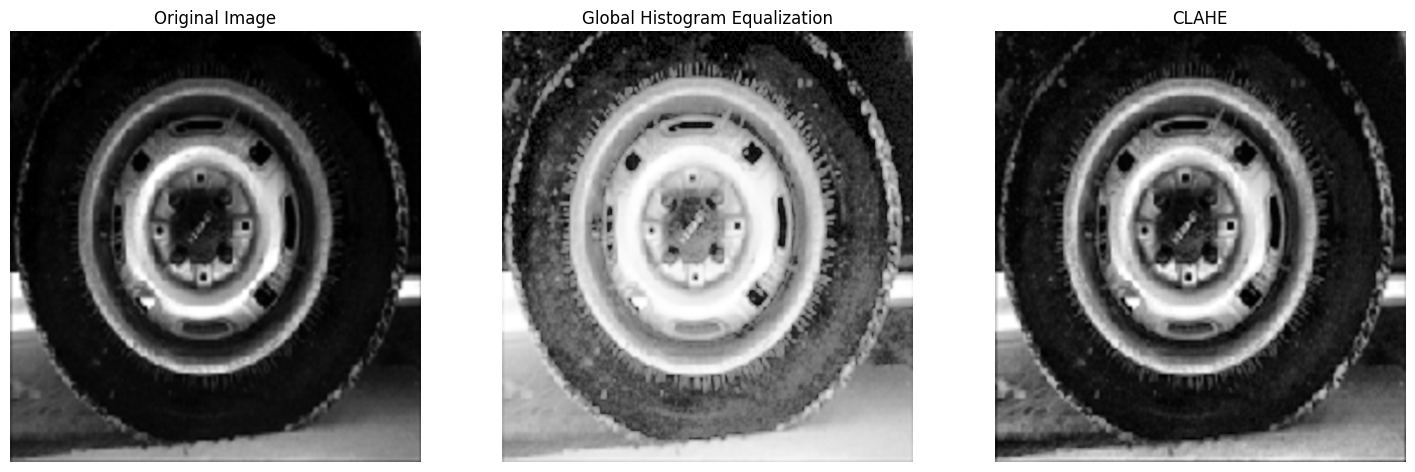

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "data/image2.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    print("Image not found!")

global_hist_eq = cv2.equalizeHist(img)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_eq = clahe.apply(img)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(global_hist_eq, cmap='gray')
ax[1].set_title('Global Histogram Equalization')
ax[1].axis('off')

ax[2].imshow(clahe_eq, cmap='gray')
ax[2].set_title('CLAHE')
ax[2].axis('off')

plt.show()


### Task 3 非线性变换（矫正）
模型的系数确定采用约束对应点方法，也称控制点方法在输入图（失真图）和输出图（校正图）上找一些其位置确切知道的点，然后利用这些点建立两幅图间其它象素空间位置的对应关系如果选取四边形的顶点，可以有4组对应点，能确定8个系数的如下双线性方程
$$
x' = a_1x + a_2y + a_3xy + a_4 \\
y' = b_1x + b_2y + b_3xy + b_4
$$


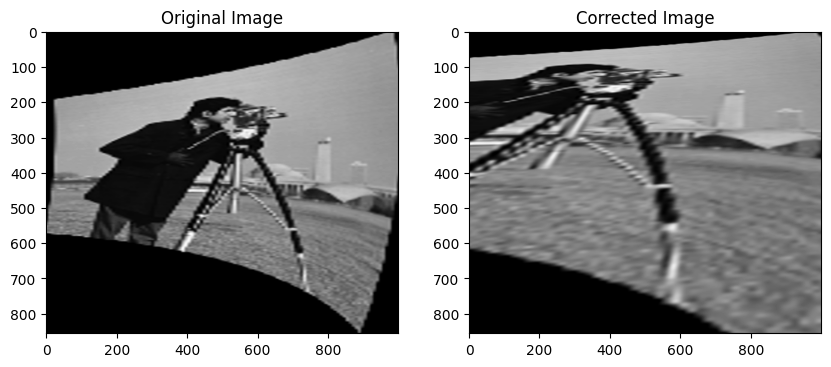

In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def correct_perspective(image, src_points, dst_points):
    # 获取透视变换矩阵
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    # 应用透视变换
    warped = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))
    return warped

# 读取图像
img = cv2.imread('data/image3.png', cv2.IMREAD_GRAYSCALE)
if img is None:
    print("Image not found!")

# 指定源点和目标点
# 注意调整这些点以反映图像中明显的四个角
src_points = np.float32([[190, 20], [1000, 0], [880, 830], [580, 800]])  # 示例，需调整
dst_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# 应用透视变换校正
corrected_img = correct_perspective(img, src_points, dst_points)

# 显示图像
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(corrected_img, cmap='gray'), plt.title('Corrected Image')
plt.show()


### Task4 彩色图形处理

用照相机拍摄人像时，有时会出现红眼现象。因为在光线较暗的环境中拍摄时，闪光灯闪光会使人眼瞳孔瞬时放大，视网膜上的血管被反射到底片上，从而产生红眼现象。去红眼技术常用的颜色模型有： RGB模型、CIE Lab模型、HSI模型。在此，采用HSI模型进行处理。统计资料表明，人像中的红眼有如下特征
$$
-\frac{\pi}{4} < h < \frac{\pi}{4} \\
s > 0.3
$$
可以设计如下的算法：
1. 确定眼部区域$R_{eye}$
2. 对$R_{eye}$中的每一个像素，将其由RGB模型转换成HSI模型
3. 将满足公式的像素饱和度$s$设置成0，即转变成灰色
4. 重复执行(2)-(3)，直到处理完$R_{eye}$中的所有像素。

In [80]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rgb_to_hsi(image):
    # Convert the RGB image to float32
    image = image.astype(np.float32) / 255.0

    # Calculate channels
    R = image[:,:,2]
    G = image[:,:,1]
    B = image[:,:,0]

    # Calculate intensity
    I = (R + G + B) / 3.0

    # Calculate saturation
    min_val = np.minimum(R, np.minimum(G, B))
    S = 1 - (3 / (R + G + B + 1e-6) * min_val)

    # Calculate hue
    num = 0.5 * ((R - G) + (R - B))
    den = np.sqrt((R - G)**2 + (R - B)*(G - B))
    theta = np.arccos(num / (den + 1e-6))
    H = np.where(B <= G, theta, 2 * np.pi - theta)
    H = H / (2 * np.pi)  # Normalize to [0, 1]

    # Combine channels into HSI image
    hsi_img = np.stack([H, S, I], axis=-1)
    return hsi_img

def hsi_to_rgb(hsi_img):
    H, S, I = hsi_img[:,:,0], hsi_img[:,:,1], hsi_img[:,:,2]
    H = H * (2 * np.pi)  # Unnormalize hue

    R, G, B = I, I, I
    cos_h = np.cos(H)
    sin_h = np.sin(H)

    def calc_channel(channel, condition, part1, part2):
        channel[condition] = I * (1 + part1 / part2)
        return channel

    r_cond = (0 <= H) & (H < 2/3*np.pi)
    R = calc_channel(R, r_cond, S * cos_h, cos_h + sin_h)

    g_cond = (2/3*np.pi <= H) & (H < 4/3*np.pi)
    G = calc_channel(G, g_cond, S * np.cos(H - 2/3*np.pi), np.cos(H - 2/3*np.pi) + np.sin(H - 2/3*np.pi))

    b_cond = (4/3*np.pi <= H) & (H < 2*np.pi)
    B = calc_channel(B, b_cond, S * np.cos(H - 4/3*np.pi), np.cos(H - 4/3*np.pi) + np.sin(H - 4/3*np.pi))

    rgb_img = np.stack([B, G, R], axis=-1)
    return (rgb_img * 255).astype(np.uint8)

# Load the image
img = cv2.imread('path_to_your_image.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert RGB to HSI
hsi_img = rgb_to_hsi(img_rgb)

# Red eye detection and removal
hue_channel = hsi_img[:,:,0]
saturation_channel = hsi_img[:,:,1]
red_eye_mask = (hue_channel > 0.9) & (hue_channel < 1.0) & (saturation_channel > 0.4)
hsi_img[:,:,1][red_eye_mask] = 0  # Set saturation to 0

# Convert back to RGB
output_img = hsi_to_rgb(hsi_img)

# Show images
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img_rgb), plt.title('Original Image')
plt.subplot(122), plt.imshow(output_img), plt.title('Red Eye Corrected')
plt.show()


error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
